In [1]:
import datasets
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np

dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'default')
df = dataset['train'].to_pandas()

# Dataset Exploration

## Overview

In [2]:
len(df.index)

135556

In [3]:
len(df.columns)

131

In [4]:
# first 15 columns
print(', '.join([f'{col}\n' if i % 4 == 0 else col for i, col in enumerate(df.columns.to_list()[:15], start=1)]))

comment_id, annotator_id, platform, sentiment
, respect, insult, humiliate, status
, dehumanize, violence, genocide, attack_defend
, hatespeech, hate_speech_score, text


In [5]:
df['comment_id'].value_counts().describe()

count    39565.000000
mean         3.426159
std         26.958077
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        815.000000
Name: count, dtype: float64

In [6]:
df['annotator_id'].value_counts().describe()

count    7912.000000
mean       17.132963
std         3.825483
min         6.000000
25%        15.000000
50%        17.000000
75%        20.000000
max        26.000000
Name: count, dtype: float64

In [7]:
df['hate_speech_score'].describe()

count    135556.000000
mean         -0.567428
std           2.380003
min          -8.340000
25%          -2.330000
50%          -0.340000
75%           1.410000
max           6.300000
Name: hate_speech_score, dtype: float64

In [8]:
df['hatespeech'].value_counts()

hatespeech
0.0    80624
2.0    46021
1.0     8911
Name: count, dtype: int64

In [9]:
df['annotator_severity'].describe()

count    135556.000000
mean         -0.018817
std           0.487261
min          -1.820000
25%          -0.380000
50%          -0.020000
75%           0.350000
max           1.360000
Name: annotator_severity, dtype: float64

## Dataset Filtering

In [10]:
def apply_criteria_for_label_counts(df, min_labels_per_annotator=1, min_labels_per_comment=1):
    # for label "hatespeech":
    # 0.0 = no, 1.0 = unclear, 2.0 = yes
    UNCLEAR_LABEL = 1.0
    df = df[df['hatespeech'] != UNCLEAR_LABEL]
    counter = 1
    while True:
        annotations_per_annotator = df['annotator_id'].value_counts()
        annotators_w_sufficient_annos = annotations_per_annotator[annotations_per_annotator >= min_labels_per_annotator]
        annotations_per_comment = df['comment_id'].value_counts()
        comments_w_sufficient_annotations = annotations_per_comment[annotations_per_comment >= min_labels_per_comment]

        df = df[df['annotator_id'].isin(annotators_w_sufficient_annos.index)]
        df = df[df['comment_id'].isin(comments_w_sufficient_annotations.index)]

        has_enough_labels_per_annotator = df['annotator_id'].value_counts().min() >= min_labels_per_annotator
        has_enough_labels_per_comment = df['comment_id'].value_counts().min() >= min_labels_per_comment
        if has_enough_labels_per_annotator and has_enough_labels_per_comment:
            break
        counter = counter + 1
    print(f'Finished after {counter} iterations.')
    return df

### Minimum Annotation Counts (Original Setting)

In [11]:
# filtered_df = apply_criteria_for_label_counts(
#     df,
#     min_labels_per_annotator = 12,
#     min_labels_per_comment = 3
# )
filtered_df = apply_criteria_for_label_counts(
    df,
    min_labels_per_annotator = 10,
    min_labels_per_comment = 3
)

filtered_df.shape

Finished after 19 iterations.


(45033, 131)

In [12]:
filtered_df['hatespeech'].value_counts()

hatespeech
0.0    28028
2.0    17005
Name: count, dtype: int64

In [13]:
filtered_df['annotator_id'].value_counts().describe()

count    3406.000000
mean       13.221668
std         2.696037
min        10.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        24.000000
Name: count, dtype: float64

In [14]:
filtered_df['comment_id'].value_counts().describe()

count    7968.000000
mean        5.651732
std        25.616463
min         3.000000
25%         3.000000
50%         3.000000
75%         4.000000
max       365.000000
Name: count, dtype: float64

### Minimum Annotation Counts (Relaxed Setting)

In [15]:
relaxed_df = apply_criteria_for_label_counts(
    df,
    min_labels_per_annotator = 12,
    min_labels_per_comment = 2
)

Finished after 17 iterations.


In [16]:
relaxed_df['hatespeech'].value_counts()

hatespeech
0.0    57368
2.0    32973
Name: count, dtype: int64

In [17]:
relaxed_df['annotator_id'].value_counts().describe()

count    5731.000000
mean       15.763567
std         2.692911
min        12.000000
25%        14.000000
50%        15.000000
75%        18.000000
max        26.000000
Name: count, dtype: float64

In [18]:
relaxed_df['comment_id'].value_counts().describe()

count    22545.000000
mean         4.007141
std         25.658153
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        590.000000
Name: count, dtype: float64

## Converting Dataset Format

In [15]:
target_columns = [
    'toxic_score',
    'text',
    'text_id',
    'annotator_id',
    'annotator_severity'
]

In [16]:
def convert_label(label):
    if label == 0.0:
        return 0
    elif label == 2.0:
        return 1
    else:
        raise ValueError(f'"label" is {label} but excepted 0.0 or 2.0')

### Original Filtering Criteria

In [17]:
target = filtered_df.rename(columns={
    'hatespeech': 'toxic_score', 
    'comment_id': 'text_id', 
    'comment': 'text'
})
target = target.drop(columns=[c for c in target.columns if not c in target_columns])
target['toxic_score'] = target['toxic_score'].apply(convert_label)

In [18]:
target

,text_id,annotator_id,toxic_score,text,annotator_severity
3,43625,7365,0,It is about time for all illegals to go back t...,0.86
10,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,0.61
12,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,0.52
15,23016,10173,0,Ladies buy a gun learn how to use it effective...,0.00
22,15758,8749,0,"No, they only do that to black people",0.47
...,...,...,...,...,...
135535,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,0.26
135536,20059,1257,0,happy pride month i'm gay URL,0.50
135537,20060,611,0,I love that you enjoy being trans.,-0.18
135538,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",0.45


In [19]:
# check if every annotator has annotated each text only once
target.apply(lambda row: f"{row['annotator_id']}+{row['text_id']}", axis=1).value_counts().max() == 1

np.True_

### Relaxed Filtering Criteria

In [20]:
relaxed_target = relaxed_df.rename(columns={
    'hatespeech': 'toxic_score', 
    'comment_id': 'text_id', 
    'comment': 'text'
})
relaxed_target = relaxed_target.drop(columns=[c for c in relaxed_target.columns if not c in target_columns])
relaxed_target['toxic_score'] = relaxed_target['toxic_score'].apply(convert_label)

NameError: name 'relaxed_df' is not defined

In [21]:
relaxed_target

NameError: name 'relaxed_target' is not defined

In [26]:
# check if every annotator has annotated each text only once
relaxed_target.apply(lambda row: f"{row['annotator_id']}+{row['text_id']}", axis=1).value_counts().max() == 1

np.True_

In [27]:
# relaxed_target.to_csv('../../data/clean/mhs_relaxed.csv', index=False)

## Summary statistics

In [21]:
# Class imbalance.
target['toxic_score'].mean()

np.float64(0.37761197344169833)

In [22]:
# Number of annotated text (minimum is set by construction).
target.groupby('annotator_id')['text_id'].count().describe()

count    3406.000000
mean       13.221668
std         2.696037
min        10.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        24.000000
Name: text_id, dtype: float64

In [23]:
# Statistics for class imbalance for each annotator.
target.groupby('annotator_id')['toxic_score'].mean().describe()

count    3406.000000
mean        0.380778
std         0.154906
min         0.000000
25%         0.272727
50%         0.363636
75%         0.500000
max         1.000000
Name: toxic_score, dtype: float64

In [24]:
# Annotator severity.
annotator_severity = target.groupby('annotator_id')['annotator_severity'].first().reset_index()

annotator_severity.describe()

,annotator_id,annotator_severity
count,3406.000000,3406.000000
mean,5551.771286,-0.009292
std,3222.011671,0.481449
min,1.000000,-1.240000
25%,2701.750000,-0.370000
50%,5606.000000,-0.010000
75%,8321.750000,0.360000
max,11142.000000,1.080000


In [25]:
annotator_severity_quantiles = (
    annotator_severity['annotator_severity']
    .quantile(q=np.arange(0.1, 1.1, 0.1))
    .reset_index()
    .rename(columns={'index': 'quantile', 'annotator_severity': 'value'})
)

annotator_severity_quantiles['n_annotators'] = annotator_severity_quantiles['value'].apply(
    lambda v: (annotator_severity['annotator_severity'] <= v).sum()
)

annotator_severity_quantiles

,quantile,value,n_annotators
0,0.1,-0.67,350
1,0.2,-0.45,686
2,0.3,-0.29,1023
3,0.4,-0.15,1388
4,0.5,-0.01,1712
5,0.6,0.12,2048
6,0.7,0.28,2410
7,0.8,0.45,2753
8,0.9,0.64,3067
9,1.0,1.08,3406


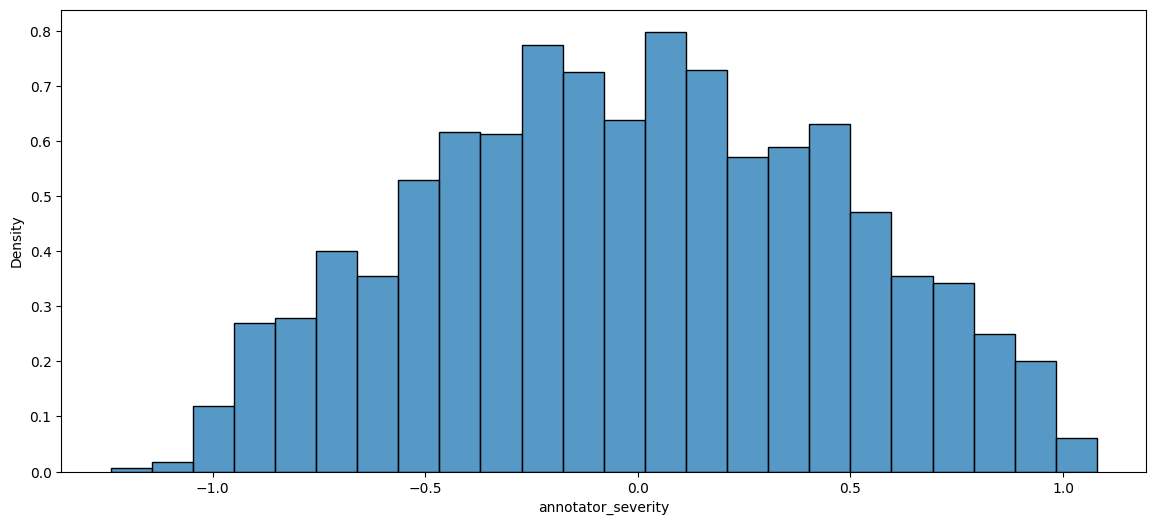

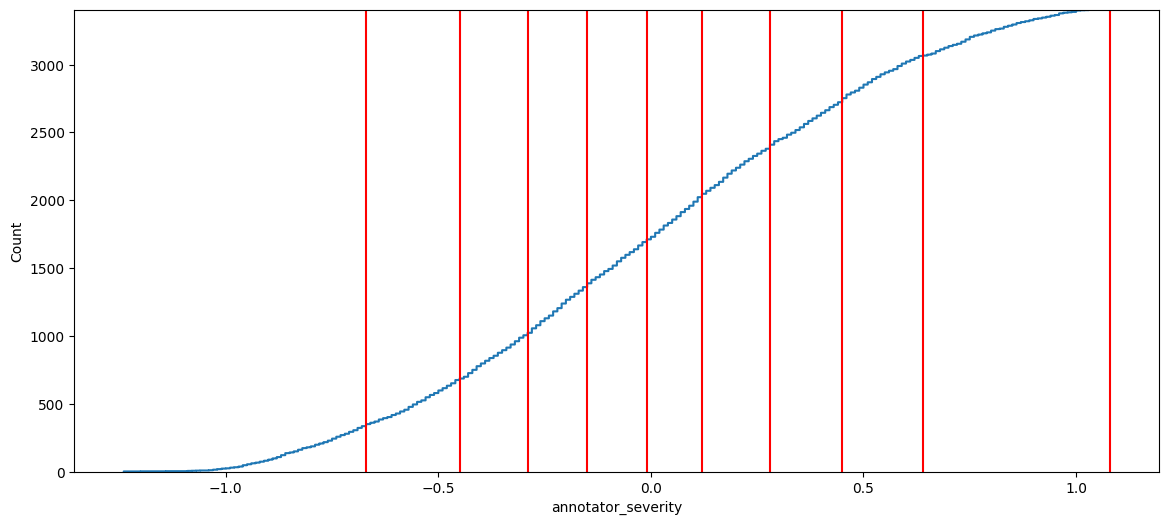

In [26]:
fig = plt.figure(figsize=(14, 6))

seaborn.histplot(
    x=annotator_severity['annotator_severity'],
    stat='density'
)


fig = plt.figure(figsize=(14, 6))

seaborn.ecdfplot(
    x=annotator_severity['annotator_severity'],
    stat='count'
)

for q, value in annotator_severity['annotator_severity'].quantile(q=np.arange(0.1, 1.1, 0.1)).items():
    plt.axvline(
        x=value,
        color='r'
    )

## Extreme Annotators (same definition used for the Kumar data)

**Problem:** using the same definition as for the Kumar data, no extreme annotators are found in the MHS dataset. Criteria can be relaxed (see below for stats if doing this). As an alternative, we can define extreme annotators as a **top** quantile in annotator severity.

In [29]:
annotators_data = pd.merge(
    left=target,
    right=(
        target
        .groupby('text_id')['toxic_score']
        .mean()
        .reset_index()
        .rename(columns={'toxic_score': 'mean_toxic_score_text'})
    ),
    on='text_id',
    how='left'
)

annotators_data['toxic_score_deviation'] = annotators_data['toxic_score'] - annotators_data['mean_toxic_score_text']

annotators_data = annotators_data.groupby('annotator_id').agg(
    n_annotated_texts=pd.NamedAgg('text_id', 'nunique'),
    annotator_severity=pd.NamedAgg('annotator_severity', 'first'),
    mean_deviation=pd.NamedAgg('toxic_score_deviation', 'mean'),
    percent_lower_50=pd.NamedAgg('toxic_score_deviation', lambda deviations: np.mean(deviations < -0.5) * 100.),
    percent_lower_40=pd.NamedAgg('toxic_score_deviation', lambda deviations: np.mean(deviations < -0.4) * 100.),
    percent_lower_30=pd.NamedAgg('toxic_score_deviation', lambda deviations: np.mean(deviations < -0.3) * 100.),
    percent_lower_20=pd.NamedAgg('toxic_score_deviation', lambda deviations: np.mean(deviations < -0.2) * 100.)
).reset_index()

annotators_data['annotator_severity_quantile'] = annotators_data['annotator_severity'].apply(
    lambda v: (annotators_data['annotator_severity'] <= v).sum() / len(annotators_data)
)

annotators_data['percent_lower'] = annotators_data['percent_lower_50']

for deviation_threshold in [50, 40, 30, 20]:
    for frac_threshold in np.arange(10, 51, 10):
        annotators_data[f'extreme_annotator_dev_{deviation_threshold}_frac_{frac_threshold}'] = annotators_data[f'percent_lower_{deviation_threshold}'] > frac_threshold

annotators_data['extreme_annotator'] = annotators_data[f'extreme_annotator_dev_50_frac_50']

annotators_data

,annotator_id,n_annotated_texts,annotator_severity,mean_deviation,percent_lower_50,percent_lower_40,percent_lower_30,percent_lower_20,annotator_severity_quantile,percent_lower,...,extreme_annotator_dev_30_frac_20,extreme_annotator_dev_30_frac_30,extreme_annotator_dev_30_frac_40,extreme_annotator_dev_30_frac_50,extreme_annotator_dev_20_frac_10,extreme_annotator_dev_20_frac_20,extreme_annotator_dev_20_frac_30,extreme_annotator_dev_20_frac_40,extreme_annotator_dev_20_frac_50,extreme_annotator
0,1,14,-0.16,0.031793,7.142857,7.142857,14.285714,14.285714,0.399295,7.142857,...,False,False,False,False,True,False,False,False,False,False
1,4,12,-0.26,-0.005149,0.000000,0.000000,0.000000,16.666667,0.325602,0.000000,...,False,False,False,False,True,False,False,False,False,False
2,9,11,1.01,0.029017,0.000000,0.000000,0.000000,0.000000,0.998532,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,12,13,0.05,0.030701,0.000000,0.000000,0.000000,7.692308,0.545508,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,14,14,0.74,-0.060843,7.142857,7.142857,21.428571,28.571429,0.935408,7.142857,...,True,False,False,False,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,11134,10,-0.89,0.176266,0.000000,0.000000,0.000000,0.000000,0.028479,0.000000,...,False,False,False,False,False,False,False,False,False,False
3402,11138,11,0.69,-0.118497,9.090909,9.090909,27.272727,27.272727,0.917499,9.090909,...,True,False,False,False,True,True,False,False,False,False
3403,11139,12,-0.63,-0.026626,8.333333,8.333333,16.666667,16.666667,0.115678,8.333333,...,False,False,False,False,True,False,False,False,False,False
3404,11141,16,-0.20,-0.013026,6.250000,6.250000,6.250000,6.250000,0.371991,6.250000,...,False,False,False,False,False,False,False,False,False,False


In [29]:
# target = pd.merge(
#     left=target,
#     right=annotators_data[['annotator_id', 'extreme_annotator']],
#     how='left',
#     on='annotator_id'
# )
# target = pd.merge(
#     left=target,
#     right=annotators_data[['annotator_id'] + [c for c in annotators_data.columns if 'extreme_annotator' in c]],
#     how='left',
#     on='annotator_id'
# )

target

,text_id,annotator_id,toxic_score,text,annotator_severity
12,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,0.52
15,23016,10173,0,Ladies buy a gun learn how to use it effective...,0.00
29,5410,123,0,Them - DON'T YOU DARE OBJECTIFY US!! ​ Also th...,0.04
49,5611,6998,0,Well this explains all the Muslim people I saw...,-0.16
82,34714,10256,0,Deep down in my inner demonic soul. I feel lik...,1.00
...,...,...,...,...,...
135490,20066,10712,0,NUGS lauds Ghanaian Muslims for their immense ...,-0.55
135504,20061,7224,0,"I, a Catholic and a Jesuit, am grateful for th...",0.13
135511,20069,3572,0,Trans rights are human rights,0.03
135522,20065,7457,0,Notwithstanding Marriyum Aurangzeb sahiba's po...,0.32


In [102]:
# text_avg_scores = target.groupby('text_id')['toxic_score'].mean()
# target['text_avg_score'] = target['text_id'].apply(lambda t: text_avg_scores[t])

# # TODO is it < -0.5 or <= -0.5 ?
# target['extreme_annotator_original'] = target.apply(lambda row: (row['toxic_score'] - row['text_avg_score']) < -0.5 , axis=1).astype(int)

# (target.groupby('annotator_id')['extreme_annotator_original'].mean() >= 0.5).any()

In [28]:
annotators_data['extreme_annotator'].sum()

np.int64(0)

In [29]:
target['extreme_annotator'].value_counts()

KeyError: 'extreme_annotator'

In [ ]:
target.groupby('annotator_id')['extreme_annotator'].first().value_counts()

### Extreme annotators VS threshold for fraction of toxic score deviations

Text(0, 0.5, 'Fraction of extreme annotators')

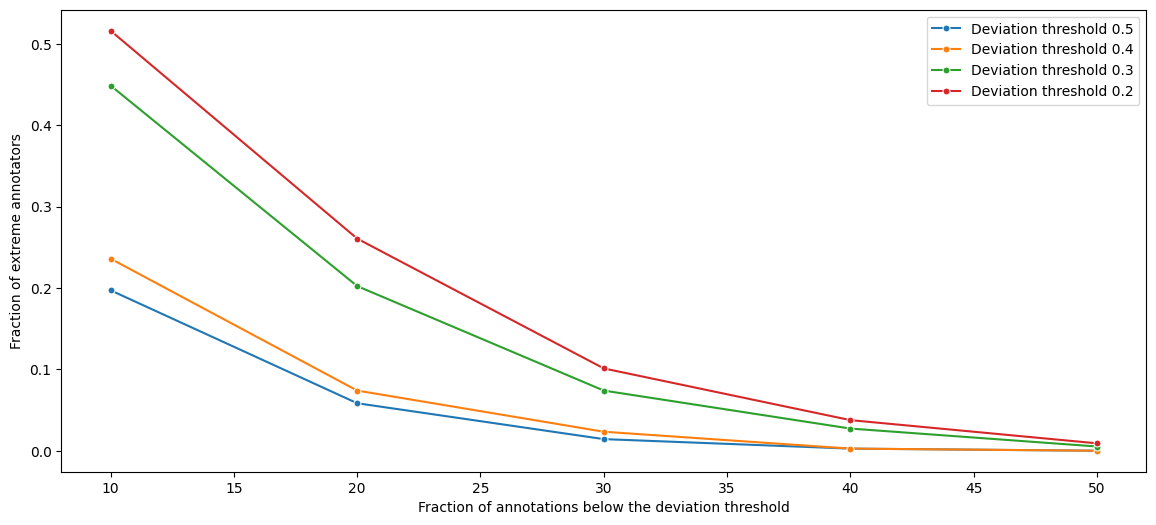

In [30]:
toxic_score_deviations_frac_thresholds = sorted(np.unique([float(c.split('_')[-1]) for c in annotators_data if 'frac' in c]))

fig = plt.figure(figsize=(14, 6))

for deviation_threshold in [50, 40, 30, 20]:
    seaborn.lineplot(
        x=toxic_score_deviations_frac_thresholds,
        y=[
            annotators_data[f'extreme_annotator_dev_{deviation_threshold}_frac_{int(ft)}'].mean()
            for ft in toxic_score_deviations_frac_thresholds
        ],
        marker='.',
        markersize=10,
        label=f'Deviation threshold {deviation_threshold * 0.01}'
    )

plt.xlabel('Fraction of annotations below the deviation threshold')
plt.ylabel('Fraction of extreme annotators')

In [31]:
annotators_data.shape

(771, 31)

### Extreme vs Severity Correlation

**Note:** this is valid only for if the definition of extreme annotators is based on deviations (otherwise the analysis is trivial by construction!).

In [ ]:
seaborn.boxplot(
    data=target,
    y='annotator_severity',
    x='extreme_annotator'
)

In [ ]:
target[target['extreme_annotator'] == 0]['annotator_severity'].describe()

In [ ]:
target[target['extreme_annotator'] == 1]['annotator_severity'].describe()

## Extreme annotators based on the annotator severity quantiles

**Idea:** instead of defining extreme annotators based on deviations w.r.t. to the average toxicity scores, define them as the top quantile of annotator severity, assuming that high severity corresponds to some notion of "extreme" annotator.

In [27]:
annotator_severity_quantiles['n_top_annotators'] = len(annotator_severity) - annotator_severity_quantiles['n_annotators']

annotator_severity_quantiles

,quantile,value,n_annotators,n_top_annotators
0,0.1,-0.67,350,3056
1,0.2,-0.45,686,2720
2,0.3,-0.29,1023,2383
3,0.4,-0.15,1388,2018
4,0.5,-0.01,1712,1694
5,0.6,0.12,2048,1358
6,0.7,0.28,2410,996
7,0.8,0.45,2753,653
8,0.9,0.64,3067,339
9,1.0,1.08,3406,0


In [30]:
top_quantile = 0.9

annotators_data['extreme_annotator_severity_quantile'] = top_quantile
annotators_data['extreme_annotator_by_severity_quantile'] = annotators_data['annotator_severity_quantile'] >= top_quantile

annotators_data

,annotator_id,n_annotated_texts,annotator_severity,mean_deviation,percent_lower_50,percent_lower_40,percent_lower_30,percent_lower_20,annotator_severity_quantile,percent_lower,...,extreme_annotator_dev_30_frac_40,extreme_annotator_dev_30_frac_50,extreme_annotator_dev_20_frac_10,extreme_annotator_dev_20_frac_20,extreme_annotator_dev_20_frac_30,extreme_annotator_dev_20_frac_40,extreme_annotator_dev_20_frac_50,extreme_annotator,extreme_annotator_severity_quantile,extreme_annotator_by_severity_quantile
0,1,14,-0.16,0.031793,7.142857,7.142857,14.285714,14.285714,0.399295,7.142857,...,False,False,True,False,False,False,False,False,0.9,False
1,4,12,-0.26,-0.005149,0.000000,0.000000,0.000000,16.666667,0.325602,0.000000,...,False,False,True,False,False,False,False,False,0.9,False
2,9,11,1.01,0.029017,0.000000,0.000000,0.000000,0.000000,0.998532,0.000000,...,False,False,False,False,False,False,False,False,0.9,True
3,12,13,0.05,0.030701,0.000000,0.000000,0.000000,7.692308,0.545508,0.000000,...,False,False,False,False,False,False,False,False,0.9,False
4,14,14,0.74,-0.060843,7.142857,7.142857,21.428571,28.571429,0.935408,7.142857,...,False,False,True,True,False,False,False,False,0.9,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3401,11134,10,-0.89,0.176266,0.000000,0.000000,0.000000,0.000000,0.028479,0.000000,...,False,False,False,False,False,False,False,False,0.9,False
3402,11138,11,0.69,-0.118497,9.090909,9.090909,27.272727,27.272727,0.917499,9.090909,...,False,False,True,True,False,False,False,False,0.9,True
3403,11139,12,-0.63,-0.026626,8.333333,8.333333,16.666667,16.666667,0.115678,8.333333,...,False,False,True,False,False,False,False,False,0.9,False
3404,11141,16,-0.20,-0.013026,6.250000,6.250000,6.250000,6.250000,0.371991,6.250000,...,False,False,False,False,False,False,False,False,0.9,False


In [32]:
annotators_data[['extreme_annotator', 'extreme_annotator_by_severity_quantile']].sum()

extreme_annotator                           1
extreme_annotator_by_severity_quantile    342
dtype: int64

### Extreme annotators VS fraction of samples annotated as non-toxic

**Note:** this analysis makes sense only if extreme annotators are defined using the annotator severity quantiles (otherwise it's trivial by construction!).

In [33]:
target = pd.merge(
    left=target,
    right=annotators_data[['annotator_id', 'extreme_annotator_by_severity_quantile']].rename(columns={'extreme_annotator_by_severity_quantile': 'extreme_annotator'}),
    on='annotator_id',
    how='left'
)

target

,text_id,annotator_id,toxic_score,text,annotator_severity,extreme_annotator
0,43625,7365,0,It is about time for all illegals to go back t...,0.86,True
1,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,0.61,False
2,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,0.52,False
3,23016,10173,0,Ladies buy a gun learn how to use it effective...,0.00,False
4,15758,8749,0,"No, they only do that to black people",0.47,False
...,...,...,...,...,...,...
45028,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,0.26,False
45029,20059,1257,0,happy pride month i'm gay URL,0.50,False
45030,20060,611,0,I love that you enjoy being trans.,-0.18,False
45031,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",0.45,False


In [35]:
target

,text_id,annotator_id,toxic_score,text,annotator_severity,extreme_annotator
0,43625,7365,0,It is about time for all illegals to go back t...,0.86,True
1,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,0.61,False
2,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,0.52,False
3,23016,10173,0,Ladies buy a gun learn how to use it effective...,0.00,False
4,15758,8749,0,"No, they only do that to black people",0.47,False
...,...,...,...,...,...,...
45028,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,0.26,False
45029,20059,1257,0,happy pride month i'm gay URL,0.50,False
45030,20060,611,0,I love that you enjoy being trans.,-0.18,False
45031,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",0.45,False


In [36]:
extreme_annotators_mean_pred_stats = target.copy()
extreme_annotators_mean_pred_stats['quantile_bin'] = pd.qcut(target['annotator_severity'], 10, labels=range(10))

# Analysis by extreme VS non-extreme annotators.
# extreme_annotators_mean_pred_stats = extreme_annotators_mean_pred_stats.groupby('annotator_id').agg(
#     mean_pred=pd.NamedAgg('toxic_score', 'mean'),
#     extreme_annotator=pd.NamedAgg('extreme_annotator', 'first')
# ).reset_index()

# Analysis by quantile bin.
extreme_annotators_mean_pred_stats = extreme_annotators_mean_pred_stats.groupby('annotator_id').agg(
    mean_pred=pd.NamedAgg('toxic_score', 'mean'),
    extreme_annotator=pd.NamedAgg('quantile_bin', 'first')
).reset_index()

extreme_annotators_mean_pred_stats

,annotator_id,mean_pred,extreme_annotator
0,1,0.428571,3
1,4,0.250000,3
2,9,0.545455,9
3,12,0.538462,5
4,14,0.285714,9
...,...,...,...
3401,11134,0.600000,0
3402,11138,0.272727,9
3403,11139,0.416667,1
3404,11141,0.312500,3


<Axes: xlabel='extreme_annotator', ylabel='mean_pred'>

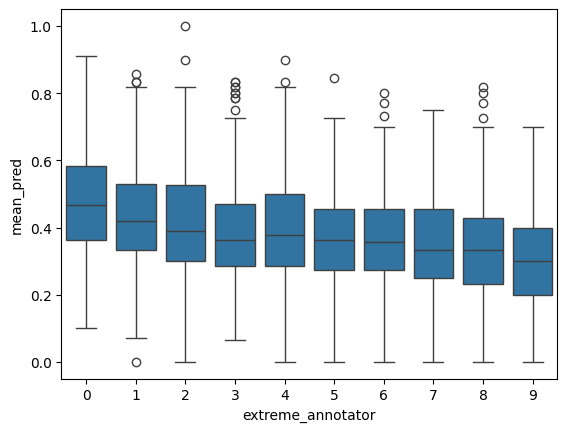

In [37]:
seaborn.boxplot(
    x=extreme_annotators_mean_pred_stats['extreme_annotator'],
    y=extreme_annotators_mean_pred_stats['mean_pred'],
)

## Save filtered data and annotators data

In [38]:
target

,text_id,annotator_id,toxic_score,text,annotator_severity,extreme_annotator
0,43625,7365,0,It is about time for all illegals to go back t...,0.86,True
1,23643,9750,0,9) uhhhh i like being lgbt a lot. i feel proud...,0.61,False
2,20583,7259,0,@terryelaineh1 @UKLabour Why do 3.8 million #5...,0.52,False
3,23016,10173,0,Ladies buy a gun learn how to use it effective...,0.00,False
4,15758,8749,0,"No, they only do that to black people",0.47,False
...,...,...,...,...,...,...
45028,20064,9905,0,Lailat al Miraj mubarak to all Muslims.. I'm w...,0.26,False
45029,20059,1257,0,happy pride month i'm gay URL,0.50,False
45030,20060,611,0,I love that you enjoy being trans.,-0.18,False
45031,20067,7414,0,"Please help support nonbinary pride, add a #Tw...",0.45,False


In [40]:
target['annotator_id'].unique().shape

(3406,)

In [41]:
# target.drop(columns=['annotator_severity', 'extreme_annotator']).to_csv('../../data/clean/mhs_10_samples_per_annotator.csv', index=False)

In [43]:
# annotators_data[
#     ['annotator_id', 'n_annotated_texts', 'annotator_severity', 'annotator_severity_quantile', 'extreme_annotator_severity_quantile', 'extreme_annotator_by_severity_quantile']
# ].rename(columns={'extreme_annotator_by_severity_quantile': 'extreme_annotator'}).to_csv('../../data/clean/annotators_data_mhs_10_samples_per_annotator.csv', index=False)

## Further exploration

In [44]:
target.groupby('text_id')['annotator_id'].count().describe()

count    7968.000000
mean        5.651732
std        25.616463
min         3.000000
25%         3.000000
50%         3.000000
75%         4.000000
max       365.000000
Name: annotator_id, dtype: float64

In [45]:
target.groupby('annotator_id')['text_id'].nunique().describe()

count    3406.000000
mean       13.221668
std         2.696037
min        10.000000
25%        11.000000
50%        13.000000
75%        15.000000
max        24.000000
Name: text_id, dtype: float64

In [46]:
(target.groupby('text_id')['toxic_score'].nunique() > 1).mean()

np.float64(0.3226656626506024)

<Axes: >

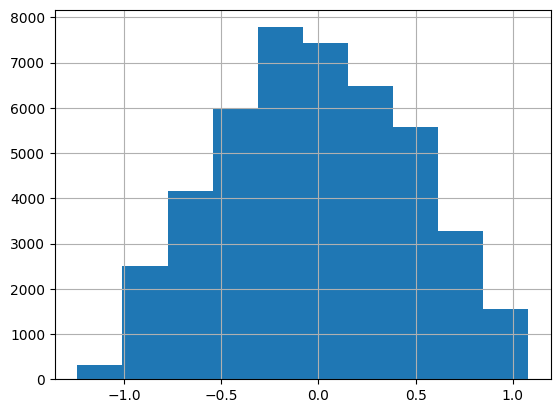

In [47]:
target['annotator_severity'].hist()

In [116]:
(target.groupby('annotator_id')['annotator_severity'].nunique() == 1).all()

np.True_

In [117]:
target.groupby('annotator_id')['annotator_severity'].first().describe()

count    771.000000
mean      -0.028677
std        0.484406
min       -1.240000
25%       -0.390000
50%       -0.020000
75%        0.340000
max        1.000000
Name: annotator_severity, dtype: float64

In [118]:
target.groupby('text_id')['toxic_score'].count().min()

np.int64(3)

Annotator severity:
- Probably, the higher, the closer to our extreme annotators (top percentile should correspond to extreme annotators).